In [38]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
from roboflow import Roboflow

from sklearn.model_selection import train_test_split

## Preparation

In [3]:
# Path to the image directory and CSV file
image_dir = "./data/imgs"
csv_file = "./data/train.csv"

# Reading the CSV file using Pandas
data = pd.read_csv(csv_file)

In [4]:
data.head()

,Image,whaleID
0,w_7812.jpg,whale_48813
1,w_4598.jpg,whale_09913
2,w_3828.jpg,whale_45062
3,w_8734.jpg,whale_74162
4,w_3251.jpg,whale_99558


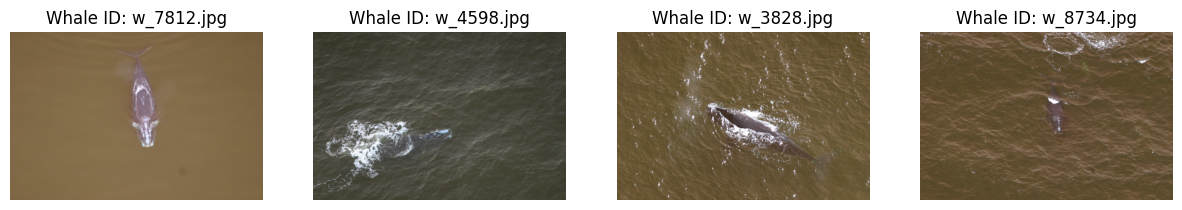

In [5]:
# Display the first four images
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i in range(4):
    image_name = data['Image'].values[i]
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        img = cv2.imread(image_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Whale ID: {image_name}")
        axes[i].axis('off')

plt.show()

## Import pretrained YOLO Model

In [17]:
rf = Roboflow(api_key="EQxthA4jdGAzqD67FiyQ")
project = rf.workspace().project("artifin")
model = project.version(2).model

loading Roboflow workspace...
loading Roboflow project...


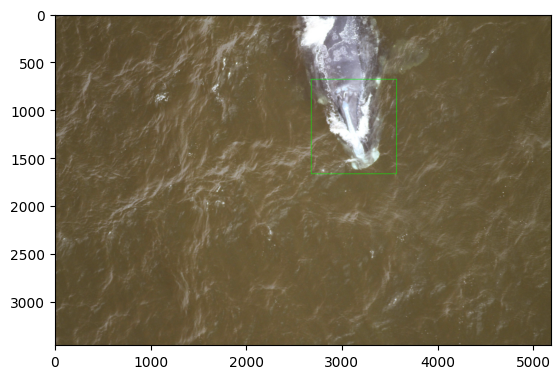

In [33]:
# visualize your prediction
image_path = os.path.join(image_dir, data['Image'][252])

image = cv2.imread(image_path)

predictions = model.predict(image_path, confidence=40, overlap=30).json()

for bounding_box in predictions["predictions"]:
    x0 = bounding_box['x'] - bounding_box['width'] / 2
    x1 = bounding_box['x'] + bounding_box['width'] / 2
    y0 = bounding_box['y'] - bounding_box['height'] / 2
    y1 = bounding_box['y'] + bounding_box['height'] / 2
    start_point = (int(x0), int(y0))
    end_point = (int(x1), int(y1))   
    cv2.rectangle(image, start_point, end_point, color=(0,255,0), thickness=3)
    plt.imshow(image)

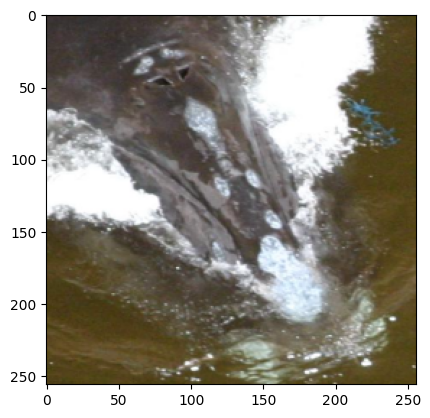

In [51]:
# Crop and rescale images
# visualize your prediction
image_path = os.path.join(image_dir, data['Image'][470])

image = cv2.imread(image_path)

predictions = model.predict(image_path, confidence=40, overlap=30).json()

for bounding_box in predictions["predictions"]:
    x0 = bounding_box['x'] - bounding_box['width'] / 2
    x1 = bounding_box['x'] + bounding_box['width'] / 2
    y0 = bounding_box['y'] - bounding_box['height'] / 2
    y1 = bounding_box['y'] + bounding_box['height'] / 2
    cropped = image[int(y0):int(y1), int(x0):int(x1)]
    resized = cv2.resize(cropped, (256,256), interpolation = cv2.INTER_AREA)
    plt.imshow(resized)

## Prepare Datasets

In [ ]:
# Build a whale id lookup dict with the respective probability tensors
n = data['whaleID'].nunique()

whale_id_dict = {}

for idx, whale_id in enumerate(sorted(data['whaleID'].unique())):
    tensor = torch.zeros(n)
    tensor[idx] = 1
    whale_id_dict[whale_id] = tensor

In [ ]:
# first
#whale_id_dict['whale_00195']

In [ ]:
# last
#whale_id_dict['whale_99573']

In [3]:
X = []
y = []

def get_y_tensor(whale_id):
    return whale_id_dict[whale_id]

for index, row in data.iterrows():
    image_name = row['Image']
    image_path = os.path.join(image_dir, image_name)
    if os.path.exists(image_path):
        sobel_image = load_images_sobel(image_path)
        X.append(sobel_image)
        y.append(get_y_tensor(row['whaleID']))

In [4]:
# Convert the lists to numpy arrays
X = np.array(X) # Images with Sobel filter
y = np.array(y) # Corresponding whale IDs

# Display the shape of the data
print(f"Shape of X (images with Sobel filter): {X.shape}")
print(f"Shape of y (whale IDs): {y.shape}")

Shape of X (images with Sobel filter): (4543, 640, 640)
Shape of y (whale IDs): (4543,)


In [5]:
X[0].shape

(640, 640)

In [6]:
y[0]

48813

In [8]:
# Define the Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.data = X
        self.labels = y

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        label = self.labels[idx]
        return torch.Tensor(image).unsqueeze(0), torch.Tensor([label])

# Create the dataset
dataset = CustomDataset(X, y)

# Split the dataset into training and testing sets
train_set, test_set = train_test_split(dataset, test_size=0.2, random_state=42)

# DataLoaders
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)